In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [2]:
import yaml
from dataset.labeled_dataset import EEGLabeledDataset, collate_fn
from models.bendr import EncoderConv, ContextNetwork, calc_loss_proper
from utils.training_utils import emb_std, emb_mean, best_ce_loss, warn_one_batch, info_about_training
from utils.data_utils import plot_spec, plot_first_n, calc_part_clipped

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import SequentialLR, LinearLR
import torch
import yaml
import numpy as np


# fix random seeds for reproducibility
SEED = 456
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

device = torch.device('mps')

with open('configs/clean_config_bendr.yaml', 'r') as file:
        cfg = yaml.safe_load(file)

dataset = EEGLabeledDataset(**cfg['data'])
loader = DataLoader(dataset, cfg['data']['batch_size'], num_workers=cfg['data']['num_workers'], 
                    persistent_workers=cfg['data']['persistent_workers'],
                    shuffle=False, drop_last=True, collate_fn=collate_fn)

encoder_sd = torch.load('/Users/ksc/Desktop/Нейротемка/code_local/neural_foundation/src/checkpoints/encoder_2024-09-22T18:53:26.264947.pt')
context_network_sd = torch.load('/Users/ksc/Desktop/Нейротемка/code_local/neural_foundation/src/checkpoints/context_network_2024-09-22T18:53:26.305446.pt')


encoder = EncoderConv(**cfg['encoder'])
context_network = ContextNetwork(**cfg['context_network'])

encoder.load_state_dict(encoder_sd)
context_network.load_state_dict(context_network_sd)

encoder = encoder.to(device)
context_network = context_network.to(device)

/var/folders/z2/jk8j2nn905v4_76cbzdgkrxm0000gn/T/ipykernel_11557/258276101.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_sd = torch.load('/Users/ksc/Desktop/Н

In [67]:
import torch.nn.functional as F
import numpy as np

def pick_negatives_DEBUG(x, num_negatives):
    # for each el in seq_len get num_negatives other els from the same batch
    batch_size, seq_len, emb_size = x.shape 
    
    self_indexes = torch.arange(seq_len, device=x.device).unsqueeze(-1).expand(-1, num_negatives) # (seq_len, num_negatives)

    neg_idxs = torch.randint(low=0, high=seq_len - 1, size=(batch_size, seq_len, num_negatives), device=x.device)
                             
    neg_idxs[neg_idxs >= self_indexes.unsqueeze(0)] += 1
    neg_idxs = neg_idxs.view(batch_size, seq_len * num_negatives, 1).expand(batch_size, seq_len * num_negatives, emb_size)

    res = torch.gather(x, 1, neg_idxs).view(batch_size, seq_len, num_negatives, emb_size)
    return res, neg_idxs

def calc_loss_DEBUG(batch, temp, num_negatives):
    features, context, mask = batch['targets'], batch['context_vectors'], batch['mask']
    batch_size, _, emb_size = features.shape
    
    masked_context = context[mask].view(batch_size, -1, emb_size)
    masked_features = features[mask].view(batch_size, -1, emb_size)
    
    num_masked = masked_features.size(1)
    
    negs, neg_ids = pick_negatives_DEBUG(masked_features, num_negatives) # (batch_size, num_masked, num_negatives, emb_size)
    batch['neg_ids'] = neg_ids
    sim_targets = torch.cat([masked_features.unsqueeze(2), negs], dim=2) # (batch_size, num_masked, 1 + num_negatives, emb_size)
    
    
    sims_raw = F.cosine_similarity(masked_context.unsqueeze(2), sim_targets, dim=3) # (batch_size, num_masked, 1 + num_negatives)

    # дальше тут надо -inf втыкать какогото хуя если негатив совпадет с таргетом идеально, ебал рот эту хуйню пока
    sims = sims_raw / temp
    sims = sims.permute(0, 2, 1) # (batch_size, 1 + num_negatives, num_masked)
    
    batch['sims'] = sims
    
    ce_target = torch.zeros(batch_size, num_masked, dtype=torch.long, device=sims.device) 
    unreduced_loss = F.cross_entropy(sims, ce_target, reduction='none')
    
    batch['per_masktoken_loss'] = unreduced_loss
    batch['loss'] = unreduced_loss.mean() 
    
    
    with torch.no_grad():
        assert sims.argmax(1).shape == (batch_size, num_masked)
        batch['acc_feature_choice'] = ((sims.argmax(1) == 0) * 1.0).mean()
        batch['mean_correct_sim'] = sims_raw[:, :, 0].mean()
        batch['mean_destractor_sim'] = sims_raw[:, :, 1:].mean()
    
    return batch


In [68]:
res = []
with torch.no_grad():
    for batch_idx, batch in enumerate(loader):
        batch['data'] = batch['data'].to(device, dtype=torch.float32)
        
        batch = encoder(batch)
        batch = context_network(batch)
        batch = calc_loss_DEBUG(batch, cfg['context_network']['temp'],  cfg['context_network']['num_negatives'])
        res.append(batch)

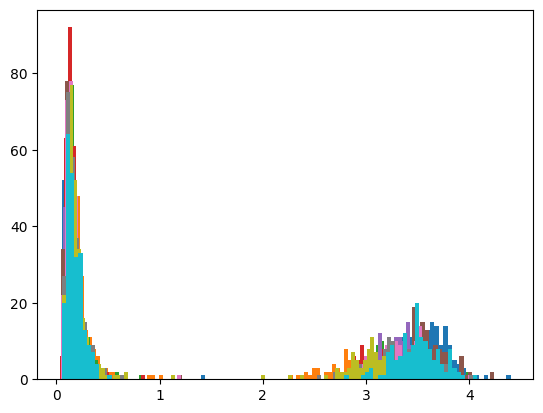

In [16]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.hist(res[i]['per_masktoken_loss'][0].cpu().detach().numpy(), bins=100)
None

loss diverges on all samples -- we can look for a cause on 1 example

In [20]:
res[0]['sims'].shape

torch.Size([2, 81, 384])

In [24]:
good = res[0]['per_masktoken_loss'][0] > 2
bad = res[0]['per_masktoken_loss'][0] > 2

tensor([0.1622, 0.1051, 0.0663, 0.0812, 0.1209, 0.1293, 0.1497, 0.0951, 0.0738,
        0.1185, 0.0911, 0.1363, 0.0811, 0.1463, 0.0716, 0.1317, 0.1114, 0.1540,
        0.1217, 0.1151, 0.1854, 0.1795, 0.1517, 0.1070, 0.1637, 0.1762, 0.0627,
        0.0630, 0.0818, 0.0989, 0.1568, 0.1212, 0.1291, 0.1829, 0.1160, 0.1524,
        0.2239, 0.1791, 0.1237, 0.1520, 0.1208, 0.1673, 0.1104, 0.1411, 0.1266,
        0.0974, 0.1696, 0.5312, 0.1224, 0.1279, 0.1347, 0.1386, 0.2300, 0.0877,
        0.0831, 0.1294, 0.5763, 0.0691, 0.0696, 0.0782, 0.0627, 0.1168, 0.1468,
        0.0961, 0.1622, 0.1805, 0.1840, 0.1421, 0.1713, 0.1817, 0.3446, 0.1833,
        0.1329, 0.1762, 0.1409, 0.1234, 0.1102, 0.0939, 0.0965, 0.1372, 0.0876,
        0.1001, 0.0817, 0.0870, 0.1103, 0.1316, 0.1429, 0.1552, 0.0767, 0.1292,
        0.0761, 0.1782, 0.1020, 0.0521, 0.1048, 0.1071, 0.0837, 0.1281, 0.0875,
        0.1343, 0.1793, 0.1036, 0.0433, 0.0939, 0.0811, 0.1085, 0.2626, 0.1279,
        0.1069, 0.1011, 0.0912, 0.1558, 

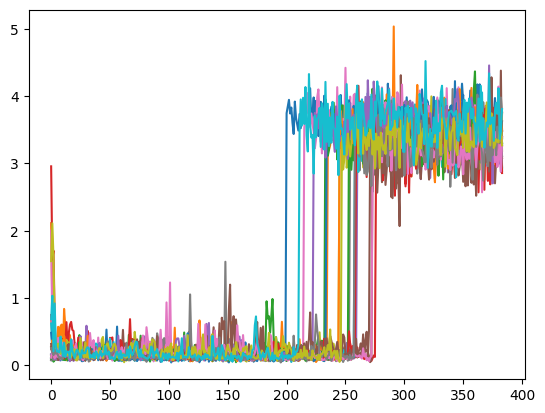

In [35]:
for i in range(10):
    plt.plot(torch.arange(384), res[i]['per_masktoken_loss'][0].detach().cpu().numpy())
    plt.plot(torch.arange(384), res[i]['per_masktoken_loss'][1].detach().cpu().numpy())

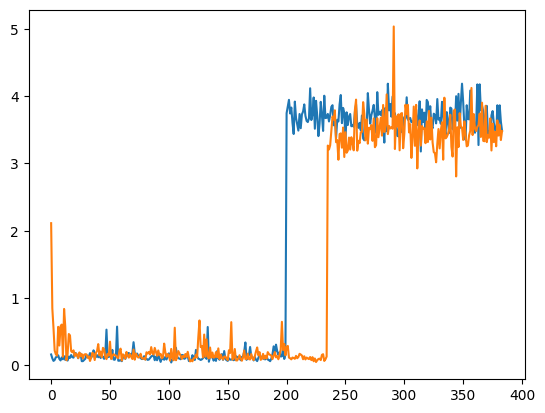

In [63]:
plt.plot(torch.arange(384), res[0]['per_masktoken_loss'][0].detach().cpu().numpy())
plt.plot(torch.arange(384), res[0]['per_masktoken_loss'][1].detach().cpu().numpy())

In [141]:
(res[0]['per_masktoken_loss'][1] < 2.5).sum()

tensor(277, device='mps:0')

In [143]:
277 * 2

554

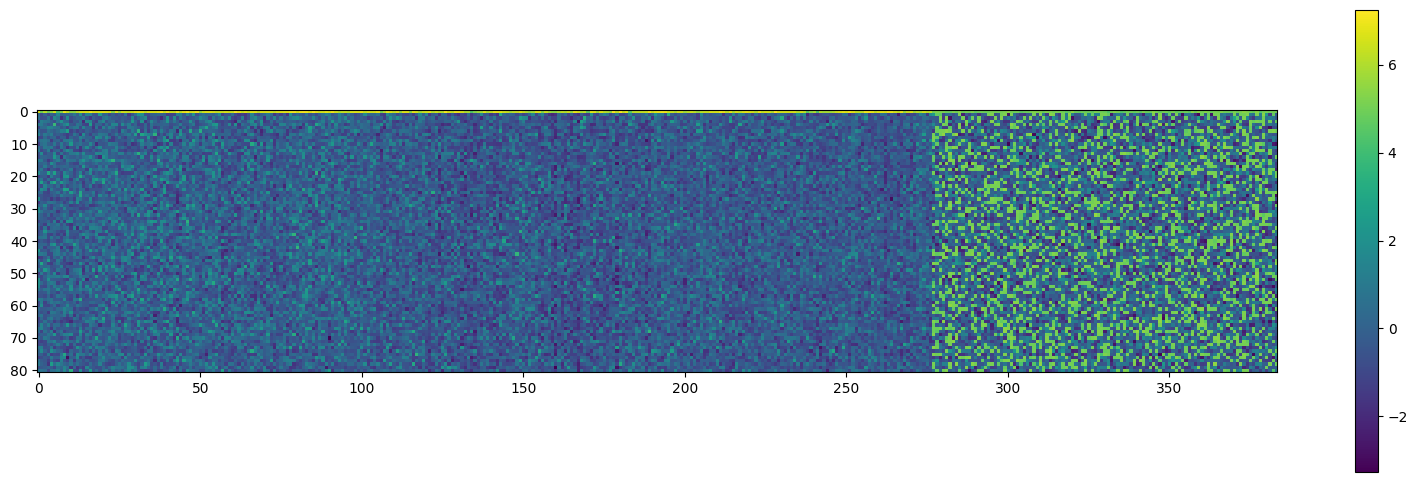

In [142]:
plt.rcParams["figure.figsize"] = (20, 6)

plt.imshow(res[0]['sims'][1].detach().cpu())
plt.colorbar()


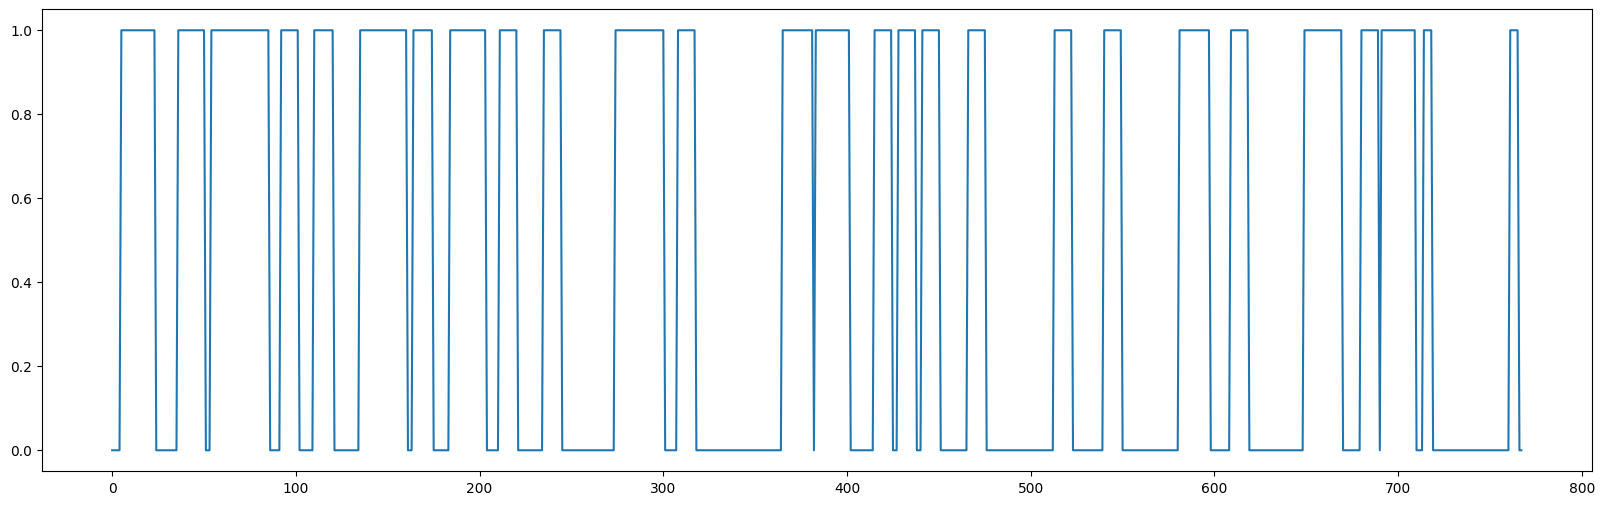

In [69]:
plt.plot(torch.arange(768), res[0]['mask'][1])

torch.Size([30720])


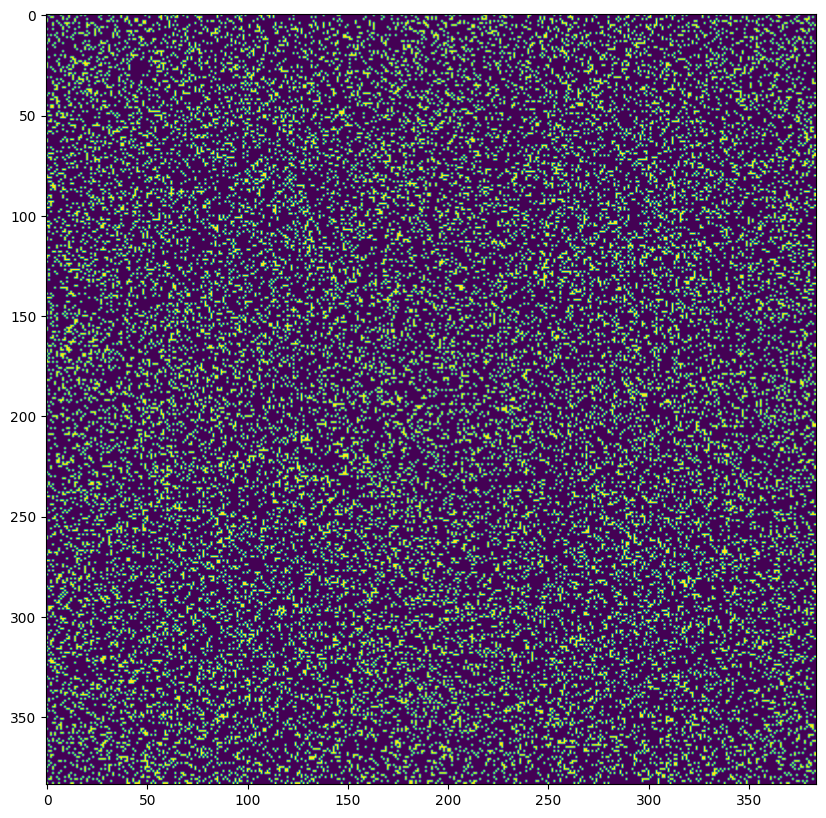

In [107]:
plt.rcParams["figure.figsize"] = (10, 10)

x = res[0]['neg_ids'][1][:, 0].detach().cpu() # seq_len, num_negatives
print(x.shape)
x = x.view(384, 80)


t = torch.zeros(384, 384)
for i in range(384):
    for j in range(80):
        t[i, x[i, j]] = 1

plt.imshow(t)

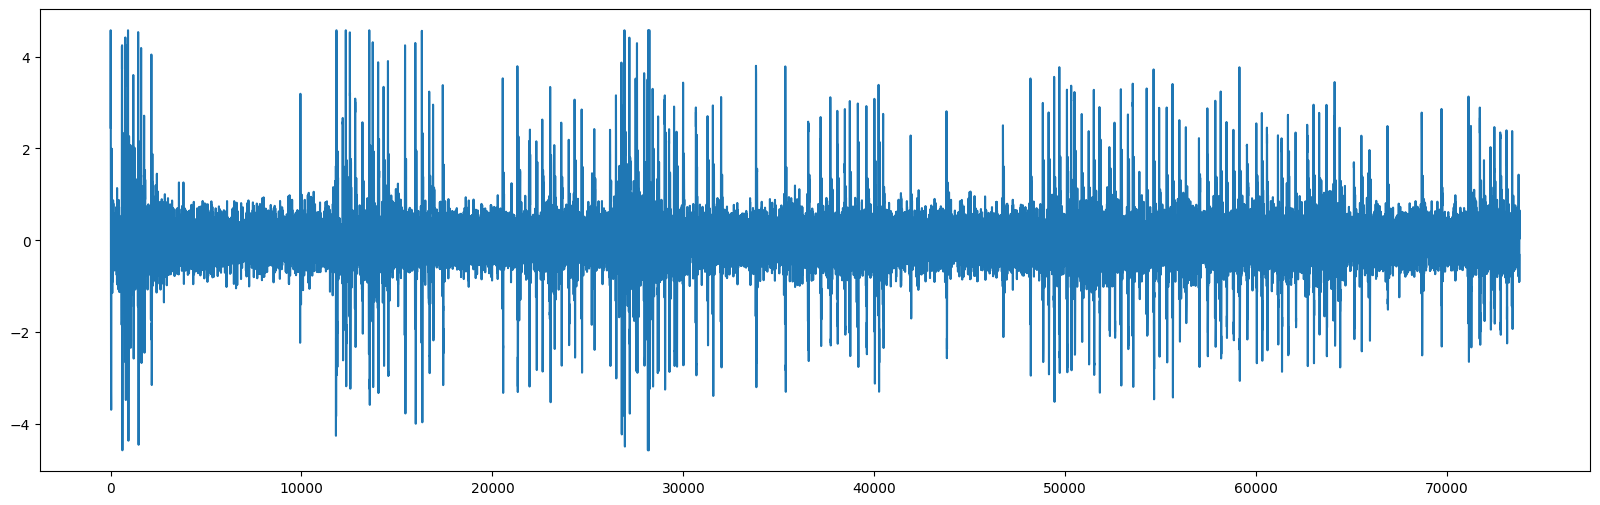

In [114]:
plt.rcParams["figure.figsize"] = (20, 6)
plt.plot(torch.arange(73800), res[0]['data'][1][1, :].detach().cpu())

In [127]:
u, s, vh = torch.pca_lowrank(res[0]['targets'][0].cpu(), q=2)

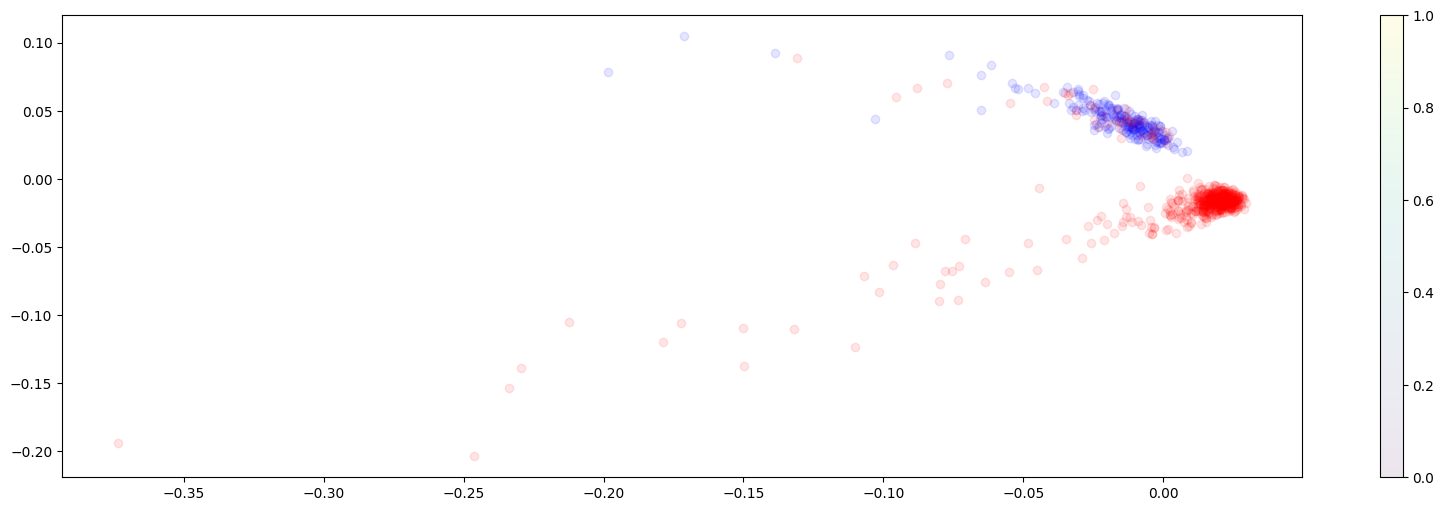

In [148]:
plt.scatter(u[554:, 0], u[554:, 1], c = 'b', alpha=0.1)
plt.scatter(u[:554, 0], u[:554, 1], c = 'r', alpha=0.1)
plt.colorbar()

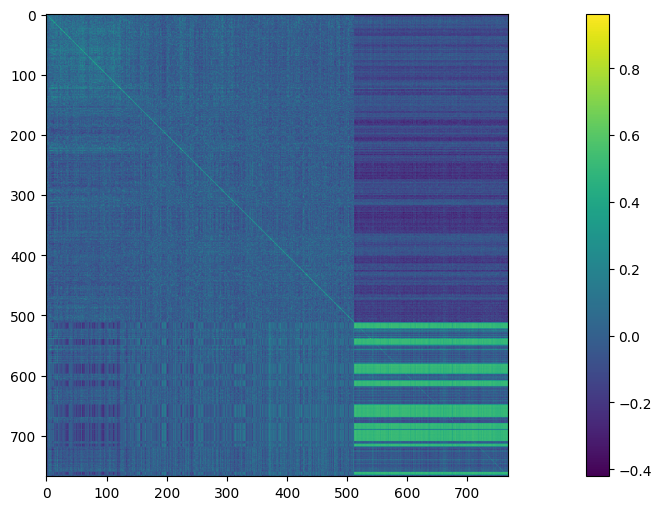

In [169]:
cont = res[0]['context_vectors'][1]
tgt = res[0]['targets'][1]

cont = cont / torch.norm(cont, dim=1, keepdim=True)
tgt = tgt / torch.norm(tgt, dim=1, keepdim=True)

# cont[300, :] = 10

sims = (cont @ tgt.T).detach().cpu()
plt.imshow(sims) # один контекст -- строчка. Для каких-то контекстов, все таргеты из подмножества идеально совпадают
plt.colorbar() # там где нет маски -- продолжается диагональ

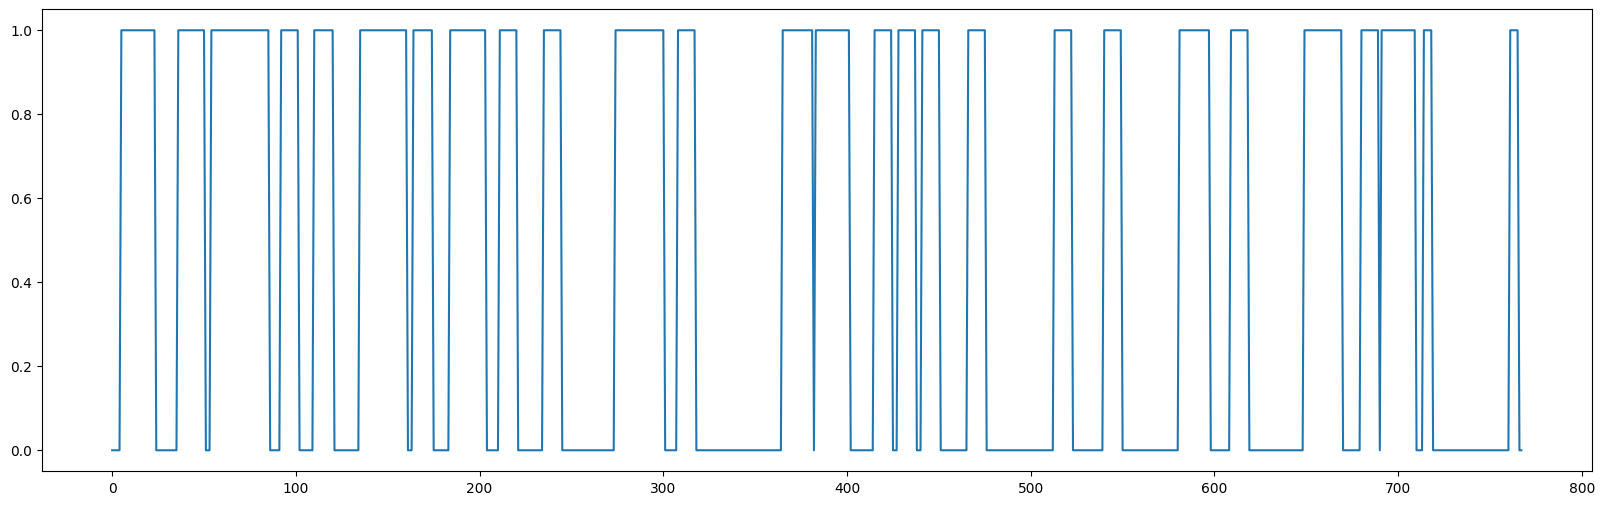

In [165]:
plt.plot(torch.arange(768), res[0]['mask'][1])

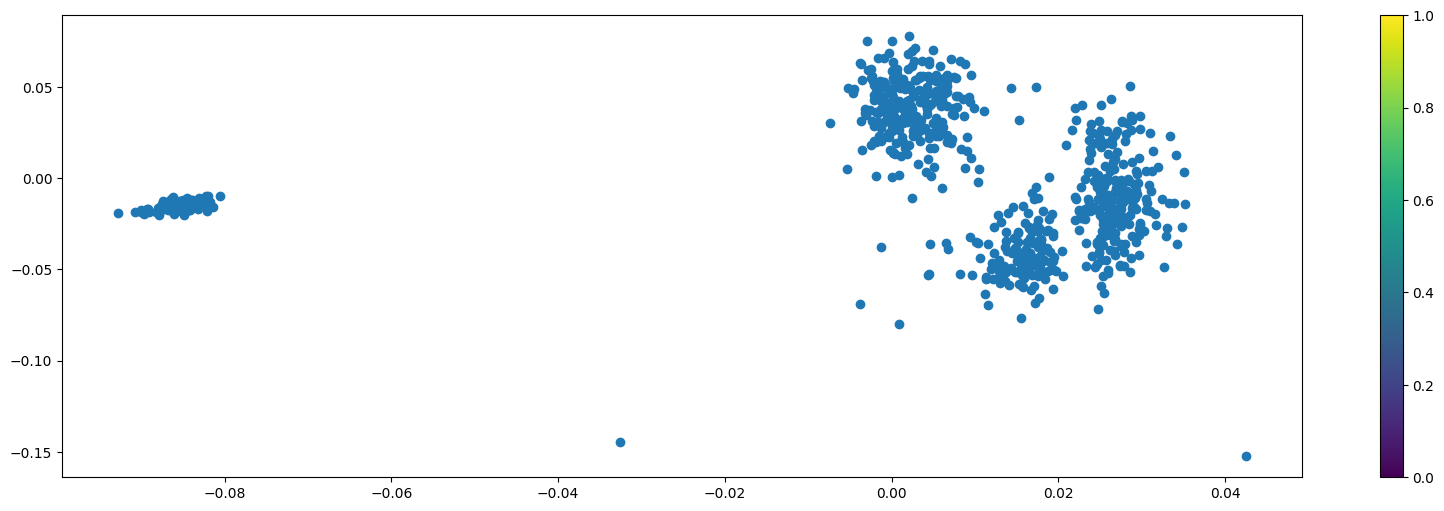

In [154]:
u, s, vh = torch.pca_lowrank(res[0]['context_vectors'][1].cpu(), q=2)
plt.scatter(u[:, 0], u[:, 1])
plt.colorbar()

In [86]:

# plt.scatter(torch.arange(x.shape[0]), x)

(array([ 85.,  90.,  72.,  68.,  77.,  89.,  87.,  88.,  70.,  73.,  76.,
         97.,  75.,  71.,  90.,  77.,  78.,  74.,  76.,  85.,  89.,  89.,
         91.,  92.,  88.,  84.,  80.,  73.,  85.,  91.,  72.,  77.,  74.,
         75.,  79.,  70.,  74.,  76.,  71., 101.,  69.,  67.,  96.,  69.,
         65.,  79.,  70.,  66.,  69.,  92.,  78.,  81.,  78.,  69.,  77.,
         85.,  72.,  62.,  86.,  90.,  86.,  74.,  74.,  90.,  90.,  76.,
         94.,  86.,  80.,  88., 102.,  53.,  51.,  88.,  68.,  75.,  75.,
        102.,  84.,  87.,  77.,  88.,  80.,  75., 101.,  77.,  81.,  75.,
         86.,  78.,  84.,  79.,  89.,  96.,  83.,  78.,  91.,  92.,  69.,
         72.,  73.,  73.,  83.,  86.,  80.,  76.,  74.,  70.,  79.,  88.,
         90.,  81.,  90.,  81.,  87.,  76.,  87.,  70.,  84.,  67.,  75.,
         82.,  81.,  69.,  75.,  85.,  64.,  66.,  83.,  91.,  76.,  72.,
         88.,  81.,  75.,  82.,  53.,  91.,  88.,  90.,  73.,  76.,  75.,
         71.,  99.,  97.,  77.,  78., 

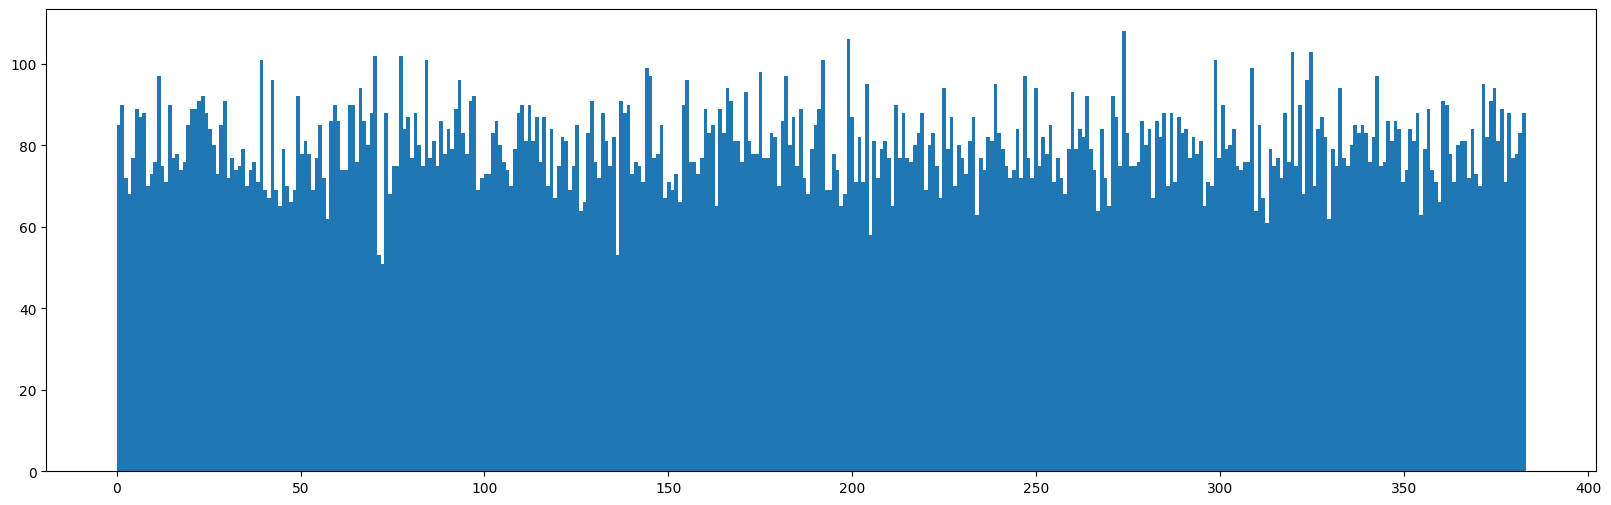

In [89]:
plt.hist(x.flatten(), bins=384)

384.0

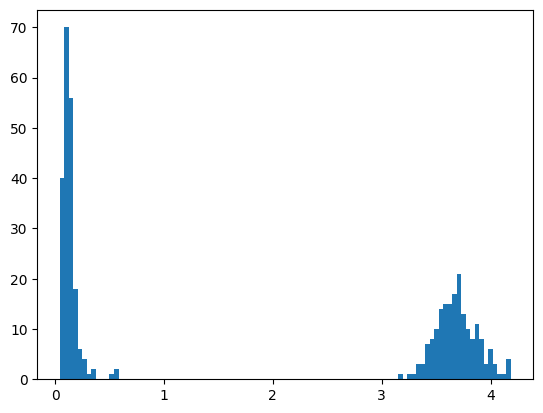

In [28]:
plt.hist(res[0]['per_masktoken_loss'][0].detach().cpu().numpy(), bins=100)
None